## New performance graphing with feature shuffle corrections

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import helper_functions as hf
import json
import os

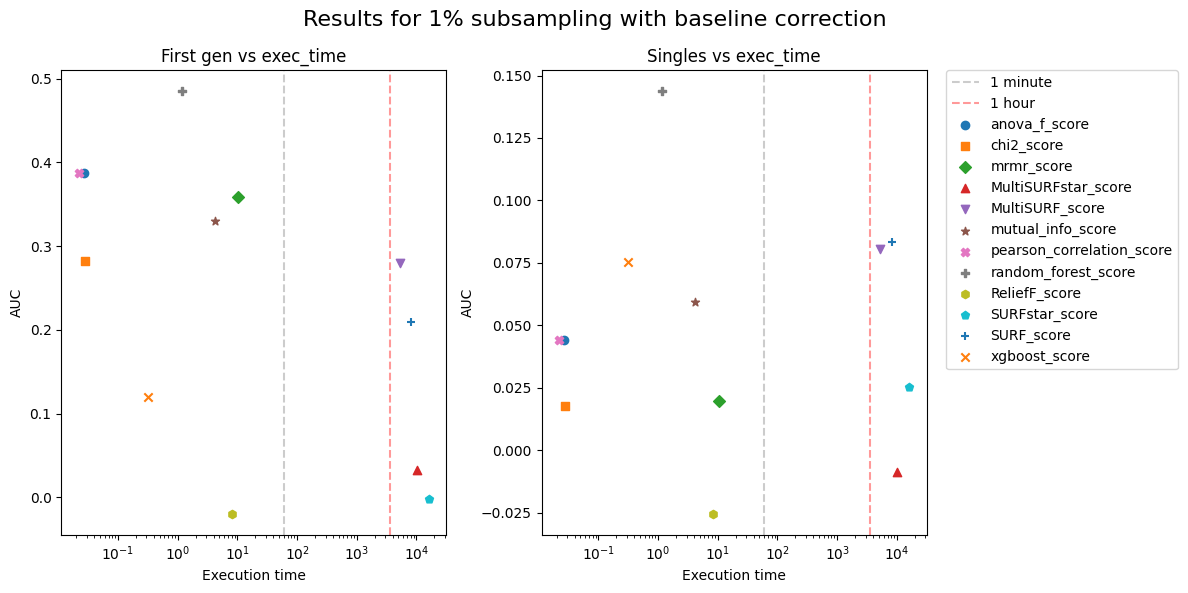

In [2]:
# Directory containing JSON files
results_dir = "results"

# Create a dictionary to hold the results
results = {}

# List of markers to cycle through
markers = ["o", "s", "D", "^", "v", "*", "X", "P", "h", "p", "+", "x", "d", "|", "_"]

# Counter for the index of the next marker to use
marker_counter = 0

# Walk through the directory
for filename in os.listdir(results_dir):
    if filename.endswith('.json'):
        filepath = os.path.join(results_dir, filename)
        
        # Access the rank_algo and subsampling_proportion
        with open(filepath, 'r') as f:
            data = json.load(f)
            
        if data.get("subsampling_proportion") == 0.01:
            # Get the rank_algo from the data
            rank_algo = data.get("rank_algo")
            
            # If this rank_algo is not yet in the results, add it with empty lists
            if rank_algo not in results:
                results[rank_algo] = {"auc_first_gen": [], "auc_singles": [], "exec_time": []}
            
            # Apply the function to each JSON file
            metrics = hf.corrected_performance_time_metric(filepath, shuffle_correction=True)

            # Add results to the dictionary
            results[rank_algo]["auc_first_gen"].append(metrics["auc_first_gen"])
            results[rank_algo]["auc_singles"].append(metrics["auc_singles"])
            results[rank_algo]["exec_time"].append(metrics["exec_time"])

# Create the plots
plt.figure(figsize=(12, 6))

# Plot for auc_first_gen
plt.subplot(1, 2, 1)

# Plot data points for each algorithm
for algo, metrics in results.items():
    plt.scatter(metrics["exec_time"], metrics["auc_first_gen"], label=algo, marker=markers[marker_counter % len(markers)])
    marker_counter += 1

plt.title('First gen vs exec_time')
plt.xlabel('Execution time')
plt.ylabel('AUC')
plt.xscale('log')

# Add vertical lines
plt.subplot(1, 2, 1)
plt.axvline(x=60, color='gray', linestyle='--', label="1 minute", alpha=0.4)
plt.axvline(x=3600, color='red', linestyle='--', label="1 hour", alpha=0.4)
plt.subplot(1, 2, 2)
plt.axvline(x=60, color='gray', linestyle='--', label="1 minute", alpha=0.4)
plt.axvline(x=3600, color='red', linestyle='--', label="1 hour", alpha=0.4)

# Display the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Plot for auc_singles
plt.subplot(1, 2, 2)

# Reset the marker counter
marker_counter = 0

# Plot data points for each algorithm
for algo, metrics in results.items():
    plt.scatter(metrics["exec_time"], metrics["auc_singles"], label=algo, marker=markers[marker_counter % len(markers)])
    marker_counter += 1

plt.title('Singles vs exec_time')
plt.xlabel('Execution time')
plt.ylabel('AUC')
plt.xscale('log')


# Display the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Add super title
plt.suptitle("Results for 1% subsampling with baseline correction", fontsize=16)

plt.tight_layout()
plt.show()

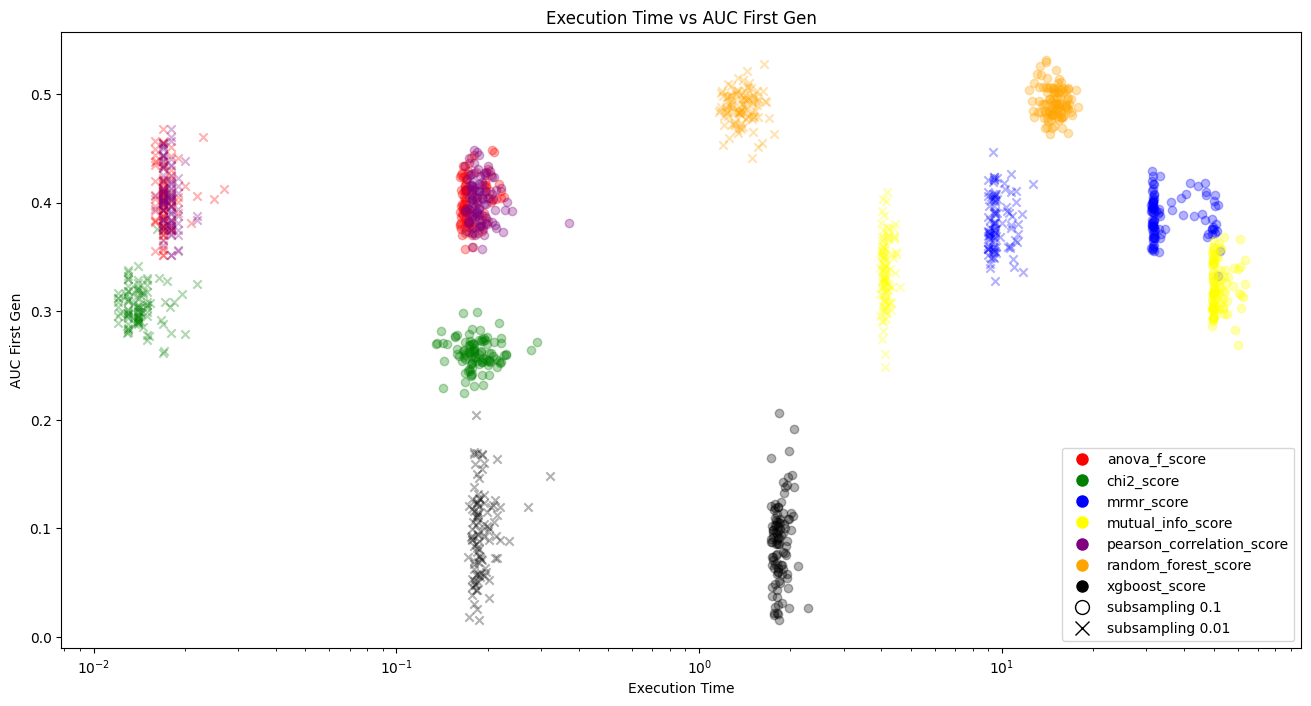

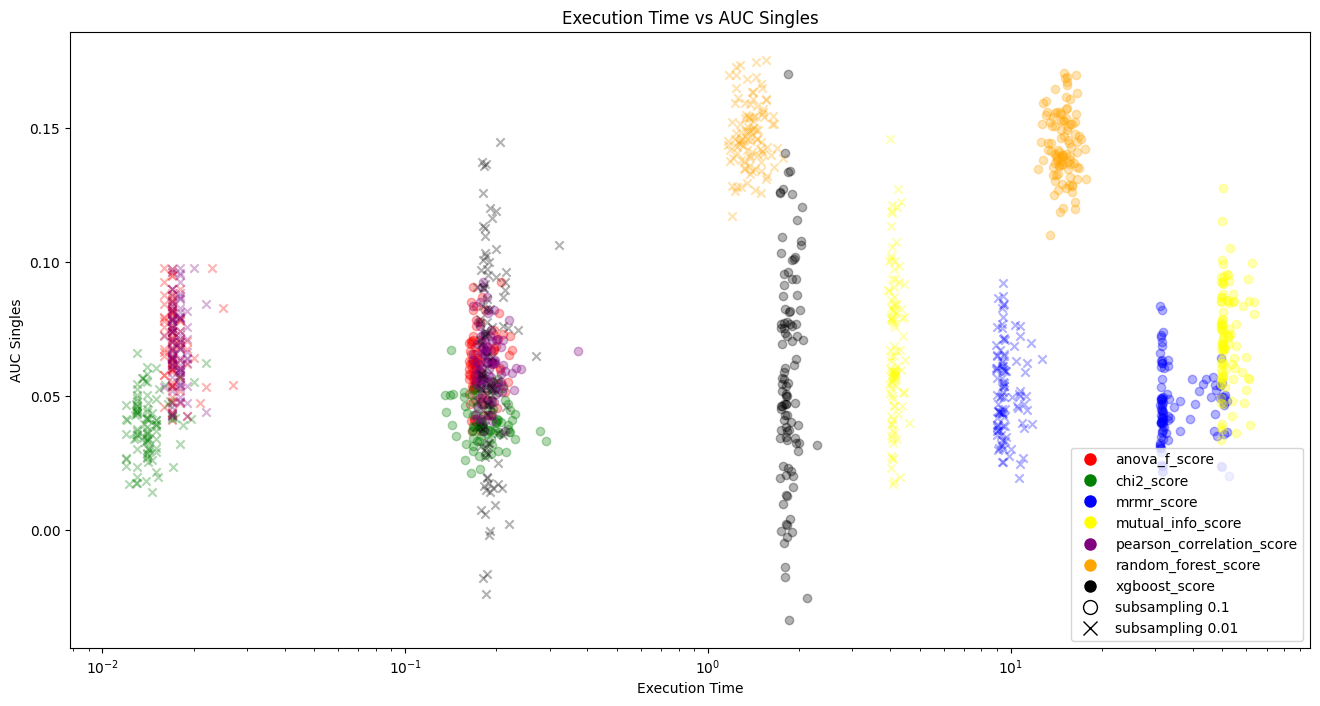

In [3]:
directories = ["anova_f_0.1_batch", "anova_f_0.01_batch",
                "chi2_0.1_batch", "chi2_0.01_batch",
                "mrmr_0.1_batch", "mrmr_0.01_batch",
                "mutual_info_0.1_batch", "mutual_info_0.01_batch",
                "pearson_correlation_0.1_new", "pearson_correlation_0.01_new",
                "random_forest_0.1_batch", "random_forest_0.01_batch",
                "xgboost_0.1_batch", "xgboost_0.01_batch"]

# Define colors and markers for each algorithm and subsampling proportion
algo_colors = {"anova_f_score": "red", "chi2_score": "green", "mrmr_score": "blue", "mutual_info_score": "yellow",
               "pearson_correlation_score": "purple", "random_forest_score": "orange", "xgboost_score": "black"}
subsampling_markers = {0.1: "o", 0.01: "x"}

# Initialize lists to store the metrics
exec_time = []
auc_first_gen = []
auc_singles = []
rank_algo = []
subsampling_proportion = []

# Iterate through each directory
for directory in directories:
    for filename in os.listdir(f'results/{directory}'):
        if filename.endswith(".json"):
            with open(f'results/{directory}/{filename}', 'r') as f:
                data = json.load(f)
            # Get metrics from hf.performance_time_metric()
            metrics = hf.corrected_performance_time_metric(f'results/{directory}/{filename}', shuffle_correction=True)
            exec_time.append(metrics['exec_time'])
            auc_first_gen.append(metrics['auc_first_gen'])
            auc_singles.append(metrics['auc_singles'])
            rank_algo.append(data['rank_algo'])
            subsampling_proportion.append(data['subsampling_proportion'])

# Create proxy artists for legend
legend_elements = []
for algo, color in algo_colors.items():
    legend_elements.append(mlines.Line2D([0], [0], marker='o', color='w', label=algo, markerfacecolor=color, markersize=10))
for prop, marker in subsampling_markers.items():
    legend_elements.append(mlines.Line2D([0], [0], marker=marker, color='w', label=f"subsampling {prop}", markeredgecolor='k', markersize=10))

# Create first scatterplot
plt.figure(figsize=(16, 8))
for i in range(len(exec_time)):
    plt.scatter(exec_time[i], auc_first_gen[i],
                 color=algo_colors[rank_algo[i]], 
                 marker=subsampling_markers[subsampling_proportion[i]],
                 alpha=0.3)
plt.title('Execution Time vs AUC First Gen')
plt.xlabel('Execution Time')
plt.ylabel('AUC First Gen')
plt.xscale('log')
plt.legend(handles=legend_elements, loc='lower right')
plt.show()

# Create second scatterplot
plt.figure(figsize=(16, 8))
for i in range(len(exec_time)):
    plt.scatter(exec_time[i], auc_singles[i], 
                color=algo_colors[rank_algo[i]], 
                marker=subsampling_markers[subsampling_proportion[i]],
                alpha=0.3)
plt.title('Execution Time vs AUC Singles')
plt.xlabel('Execution Time')
plt.ylabel('AUC Singles')
plt.xscale('log')
plt.legend(handles=legend_elements, loc='lower right')
plt.show()